# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [144]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
import os
import seaborn as sb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

import scipy
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from numpy import savetxt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc 

In [160]:
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

In [41]:
data_path = os.path.join("data/data.csv")
data = pd.read_csv(data_path, index_col=False)
data.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,...,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,...,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,...,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,...,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,...,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,...,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [42]:
#drop duration value
del data['duration']

In [43]:
data.head()

,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,subscribed
0,41.0,blue-collar,married,basic.9y,no,yes,no,cellular,apr,mon,2.0,999,0,nonexistent,-1.695118,92.698705,-46.727552,1.345160,5097.0,no
1,46.0,entrepreneur,married,unknown,no,no,no,cellular,may,wed,2.0,999,0,nonexistent,-1.767159,92.914878,-46.313088,1.314499,5100.0,no
2,56.0,unemployed,married,basic.9y,no,yes,yes,cellular,nov,fri,1.0,999,0,nonexistent,-0.100365,93.423076,-41.904559,4.003471,5193.0,no
3,89.0,retired,divorced,basic.4y,no,yes,no,cellular,may,wed,4.0,999,0,nonexistent,-1.771314,93.672814,-46.045500,1.261668,5100.0,no
4,34.0,entrepreneur,married,university.degree,unknown,yes,no,cellular,jul,thu,8.0,999,0,nonexistent,1.458103,94.296285,-42.455877,5.152077,5233.0,no


In [44]:
data.subscribed.value_counts()

no     29238
yes     3712
Name: subscribed, dtype: int64

The dataset is imbalance, as the positive class only account for about 10% of the total classes. We will be mindful of this in implementing our models

In [25]:
numeric_vars = data.columns[data.dtypes != "object"]
numeric_vars

Index(['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'categories'],
      dtype='object')

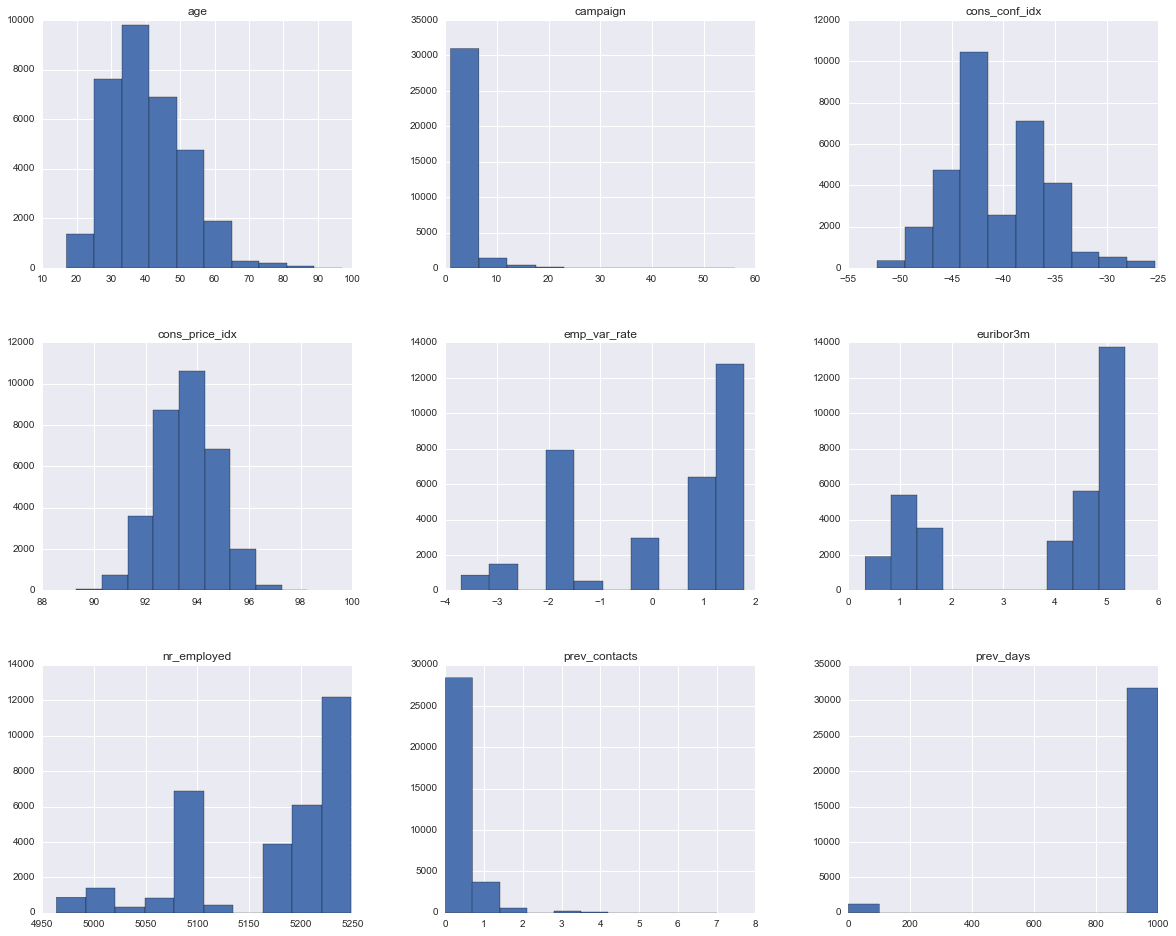

In [28]:
data[numeric_vars].hist(figsize=(20,16));


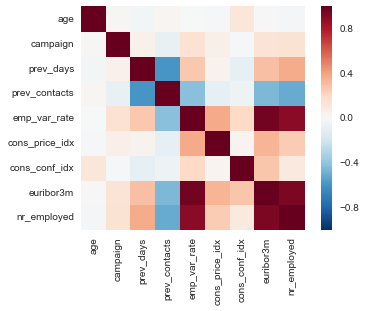

In [27]:
numeric_vars = data.columns[data.dtypes != "object"]
corrmat = data.corr()
sb.heatmap(corrmat, square=True)

From the correlation matrix above, we can see that the following pairs of continuous data are highly correlated with each other: 
- uribor3m and nr_employed
- emp_var_rate and nr_employed
- prev_days and prev_contacts
- nr_employed and prev_contacts

We will be mindful of this fact when it comes to feature engineer and model building

# Feature Engineer
We engineer our features and use this dataset for both tree and non-tree models

In [26]:
#Inspect the categorical data
categorical_vars = data.columns[data.dtypes == "object"]
categorical_vars

Index(['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'prev_outcomes', 'income',
       'age_group', 'prev_contact_no', 'prev_days_no'],
      dtype='object')

In [45]:
lab = LabelEncoder()

y = data["subscribed"]
y = lab.fit_transform(y)
data = data.drop('subscribed',axis=1)

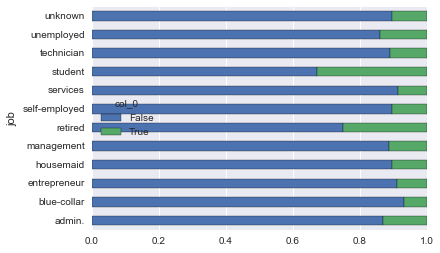

In [46]:
yes_counts = pd.crosstab([data.job], y.astype(bool))
yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)

We can see that student and retired are the two groups that have the most term deposit, they are also two groups that
don't have an income, so I will add an indicator variable called income, which tell us whether they have income or not

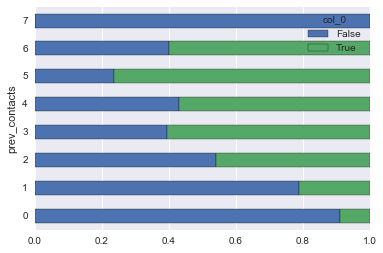

In [47]:
yes_counts = pd.crosstab([data.prev_contacts], y.astype(bool))
yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)

Majority of people with prev contacts tend to subscribe, We will add another binary feature indicating whether the
person has been contacted before

In [48]:
bins = [0, 10,20,30, 40,50, 60,70,80, 90,100]
group_names = ['0-10','10-20' ,'20-30','30-40', '40-50','50-60', '60-70','70-80','80-90','90-100']
data['categories'] = pd.cut(data['age'], bins, labels=group_names)


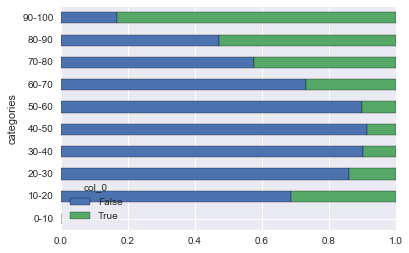

In [49]:
yes_counts = pd.crosstab([data['categories']], y.astype(bool))
yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True)

We will also add a binary feature for age group, 0 is it's between 20 - 50, 1 otherwise

In [50]:
data['income'] = ((data.job == 'student')|(data.job == 'retired')).astype('object')
data['age_group'] = ((data.age < 20 )|(data.age > 55)).astype('object')

In [51]:
data['prev_contact_no'] = (data.prev_contacts == 0 ).astype('object')
data['prev_days_no'] = (data.prev_days == 999 ).astype('object')

In [52]:
data2 = data.copy()
del data2['categories']


In [53]:

def format_pipe(X_df):
    #rescaling numeric variables and label encoding the categorical variables
    categorical_vars = X_df.columns[X_df.dtypes == "object"]
    numeric_vars = X_df.columns[X_df.dtypes != "object"]
    
    scaler = MaxAbsScaler()
    scaler.fit(X_df[numeric_vars])
    X_scaled = scaler.transform(X_df[numeric_vars])
    X_scaled = pd.DataFrame(X_scaled, columns = numeric_vars) #this df only contains scaled numerics
    
    lab = LabelEncoder()
    
    X_df.job = lab.fit_transform(X_df.job)
    X_df['marital_status'] = lab.fit_transform(X_df['marital_status'])
    X_df.education = lab.fit_transform(X_df.education)
    X_df['credit_default'] = lab.fit_transform(X_df['credit_default'])
    X_df.housing = lab.fit_transform(X_df.housing)
    X_df.loan = lab.fit_transform(X_df.loan)
    X_df.contact = lab.fit_transform(X_df.contact)
    X_df.month = lab.fit_transform(X_df.month)
    X_df['day_of_week'] = lab.fit_transform(X_df['day_of_week'])
    X_df['prev_outcomes'] = lab.fit_transform(X_df['day_of_week'])
    X_df['income'] = lab.fit_transform(X_df['income'])
    X_df['age_group'] = lab.fit_transform(X_df['age_group'])
    X_df['prev_contact_no'] = lab.fit_transform(X_df['prev_contact_no'])
    X_df['prev_days_no'] = lab.fit_transform(X_df['prev_days_no'])
    
    X_scaled[categorical_vars] = X_df[categorical_vars]
    
    return(X_scaled)

In [34]:
X_data2 = format_pipe(data2)

In [144]:
X_data2.head()

,age,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,job,...,housing,loan,contact,month,day_of_week,prev_outcomes,income,age_group,prev_contact_no,prev_days_no
0,0.422680,0.035714,1.0,0.0,-0.458723,0.943373,-0.894808,0.250850,0.971042,1,...,2,0,0,0,1,1,0,0,1,1
1,0.474227,0.035714,1.0,0.0,-0.478219,0.945573,-0.886871,0.245132,0.971614,2,...,0,0,0,6,4,4,0,0,1,1
2,0.577320,0.017857,1.0,0.0,-0.027160,0.950745,-0.802450,0.746582,0.989331,10,...,2,2,0,7,0,0,0,1,1,1
3,0.917526,0.071429,1.0,0.0,-0.479343,0.953286,-0.881747,0.235280,0.971614,5,...,2,0,0,6,4,4,1,1,1,1
4,0.350515,0.142857,1.0,0.0,0.394584,0.959631,-0.813007,0.960778,0.996952,2,...,2,0,0,3,2,2,0,0,1,1


In [31]:
#Feature selection is not super helpful
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X_data2, y)

/Users/hoadang/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


(0, 10)

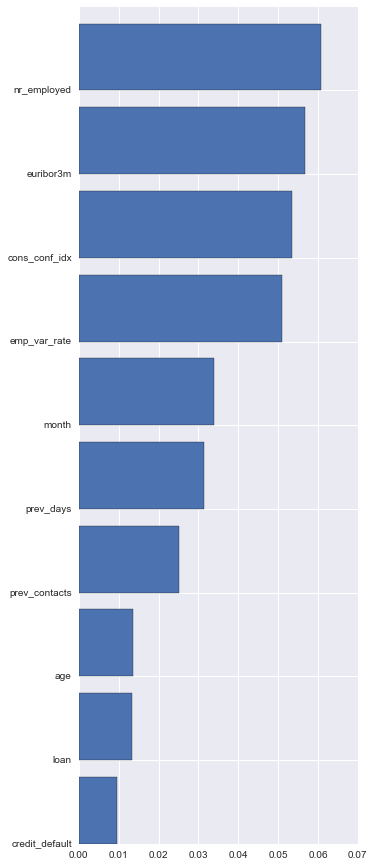

In [32]:
top_n = 10
inds = np.argsort(mi)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), mi[inds[-top_n:]])
plt.yticks(np.arange(top_n), X_data1.columns[inds[-top_n:]])
plt.ylim(0, top_n)

Feature selections does not make a large impact to the model result as we do not have a lot of features

# ModelSet1: Non- Tree Models 


In [145]:
X_data2_poly = PolynomialFeatures(interaction_only=True).fit_transform(X_data2)

In [35]:
#Logistic Regression Grid - class weight is set to balance due to unbalanced dataset
grid_LR = [{'C': [0.001,0.01,1, 10, 100, 1000], 'class_weight': ['balanced']}]
grid_logit = GridSearchCV(LogisticRegression(),param_grid=grid_LR,cv=5,scoring = 'roc_auc')
grid_logit.fit(X_data2,y)
print (grid_logit.best_params_,grid_logit.best_score_)


{'C': 1000, 'class_weight': 'balanced'} 0.7860069674676811


In [36]:
np.mean(cross_val_score(LogisticRegression(C=1000,class_weight='balanced'), X_data1, y, cv=5, scoring="roc_auc"))

0.78548189707066496

In [39]:
from sklearn.neighbors import KNeighborsClassifier
grid_knn = [{'n_neighbors': [5,10,15,20,50,100,150,200]}]
grid_KNN = GridSearchCV(KNeighborsClassifier(),param_grid=grid_knn,cv=5,scoring = 'roc_auc')
grid_KNN.fit(X_data2,y)
grid_KNN.best_params_


{'n_neighbors': 200}

In [44]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=200), X_data2, y, cv=5, scoring="roc_auc"))

0.75498533832433279

In [42]:
#Linear SVC
from sklearn.svm import LinearSVC

grid_svc = [{'C': np.logspace(-10, 0, 10)}]
grid_SVC = GridSearchCV(LinearSVC(),param_grid=grid_svc,cv=5,scoring = 'roc_auc')
grid_SVC.fit(X_data2, y)
grid_SVC.best_params_


{'C': 0.0059948425031894209}

In [45]:
grid_SVC.best_score_

0.773665749783417

In [46]:
np.mean(cross_val_score(LinearSVC(C = .00599), X_data2, y, cv=5, scoring="roc_auc"))

0.77366647505911068

## Final Non-tree model

In [186]:
from sklearn.feature_selection import SelectPercentile

log_pipe = make_pipeline(PolynomialFeatures(interaction_only=True),LogisticRegression(C=1000,class_weight='balanced'))
np.mean(cross_val_score(log_pipe, X_data2, y, cv=5, scoring="roc_auc"))

# Step3 - ModelSet2 [35 points]


In [47]:
#XGBoost with no optimal parameter
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

np.mean(cross_val_score(XGBClassifier(),X_data2,y,cv=5,scoring='roc_auc'))

0.79804072303340634

In [48]:
#XGBoost param grid search
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}


optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 
optimized_GBM.fit(X_data2,y)
optimized_GBM.best_params_

{'max_depth': 3, 'min_child_weight': 5}

In [49]:
#XGBoost param grid search 2
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 5}

optimized_GBM1 = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 
optimized_GBM1.fit(X_data2,y)
print(optimized_GBM1.best_params_, optimized_GBM1.best_score_)

{'learning_rate': 0.01, 'subsample': 0.8} 0.799248056830065


In [155]:
#cross val score of XGBoost using best parameters
np.mean(cross_val_score(XGBClassifier(learning_rate= 0.01, seed=0, subsample= 0.8, colsample_bytree= 0.8, 
             objective= 'binary:logistic', max_depth=3, min_child_weight=3,
             n_estimators= 1000),X_data2_poly,y,cv=5,scoring='roc_auc'))

0.79961741957774524

In [51]:
#Random Forest grid search
grid_RF = [{'max_depth': [5, 10, 15], 'criterion': ['entropy', 'gini'], 
            'n_estimators': [50, 100, 250], 'class_weight': ['balanced']}]

grid = GridSearchCV(RandomForestClassifier(),param_grid=grid_RF,cv=5,scoring = 'roc_auc')
grid.fit(X_data2,y)
print(grid.best_params_,grid.best_score_)

{'criterion': 'entropy', 'n_estimators': 250, 'max_depth': 10, 'class_weight': 'balanced'} 0.7973770972007838


In [53]:
#Tested random forest with understampler, no change
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

np.mean(cross_val_score(RandomForestClassifier(class_weight = 'balanced',criterion = 'entropy',max_depth = 10,
                                                n_estimators=250), X_data2, y, cv=5, scoring='roc_auc'))

0.79796376547673087

In [57]:
grid_DT = [{'criterion': ['entropy', 'gini'], 'max_depth': [3,5, 10, 15]}]
grid_detree = GridSearchCV(DecisionTreeClassifier(),param_grid=grid_DT,cv=5,scoring = 'roc_auc')
grid_detree.fit(X_data2,y)
print(grid_detree.best_params_,grid_detree.best_score_)

{'criterion': 'entropy', 'max_depth': 5} 0.7815963255390246


In [74]:
np.mean(cross_val_score(DecisionTreeClassifier(criterion='entropy',max_depth=5), 
                        X_data2, y, cv=5, scoring='roc_auc'))

0.78151838938285212

In [163]:
from sklearn.ensemble import GradientBoostingClassifier
#cross_val_score(GradientBoostingClassifier(),X_data1,y,cv=10,scoring='roc_auc')

In [61]:
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              'max_features': [1.0, 0.3, 0.1] 
              }

grid_detree = GridSearchCV(GradientBoostingClassifier(),param_grid=gb_grid_params,cv=5,scoring = 'roc_auc')
grid_detree.fit(X_data2,y)
print(grid_detree.best_params_,grid_detree.best_score_)

{'learning_rate': 0.05, 'min_samples_leaf': 100, 'max_depth': 8, 'max_features': 0.3} 0.7993762343619186


In [157]:
np.mean(cross_val_score(GradientBoostingClassifier(max_features=.3,learning_rate=.05,min_samples_leaf=100,max_depth =8), 
                        X_data2_poly, y, cv=5, scoring='roc_auc'))

0.79899908856449986

In [134]:
final_model = XGBClassifier(learning_rate= 0.01, seed=0, subsample= 0.8, colsample_bytree= 0.8, 
             objective= 'binary:logistic', max_depth=3, min_child_weight=3,
             n_estimators= 1000
final_model.fit(X_data2_poly, y)
untransformed_prediction = temp_model.predict(X_data2_poly)
print(untransformed_prediction)

prob_prediction = temp_model.predict_proba(X_data2_poly)[:,1]

[0 0 0 ..., 0 1 0]


In [135]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

print(precision_recall_fscore_support(y, untransformed_prediction, average="binary"))
confusion_matrix(y, untransformed_prediction)


(0.44658199477026522, 0.64412715517241381, 0.52746525479814688, None)


array([[26275,  2963],
       [ 1321,  2391]])

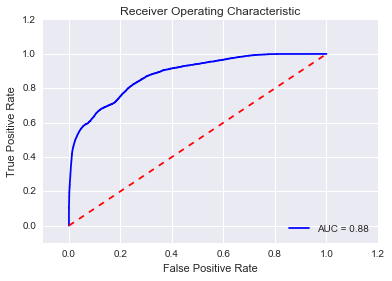

In [139]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [138]:
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt 

print(prob_prediction)
fpr, tpr, thresholds = roc_curve(y, prob_prediction)
roc_auc = auc(fpr, tpr)
print(roc_auc)

[ 0.42363126  0.46876289  0.24774425 ...,  0.30297168  0.65354159
  0.23339259]
0.880239725154


# Ensemble Methods



### Poor man stacking: Averaging all models

In [165]:
voting = VotingClassifier([('gbc',GradientBoostingClassifier(max_features=.3,learning_rate=.05,min_samples_leaf=100,max_depth =8)),
                           ('XGB',XGBClassifier(learning_rate= 0.01, subsample= 0.8, colsample_bytree= 0.8, 
                                      max_depth=3, min_child_weight=3,n_estimators= 1000)),
                             ('rf',RandomForestClassifier(class_weight = 'balanced',criterion = 'entropy',
                                                          max_depth = 10,n_estimators=250))],
                             voting = 'soft')


np.mean(cross_val_score(voting,X_data2_poly,y,cv=5,scoring='roc_auc'))

In [174]:
#Calibrate Classifer to be used in the prediction
X_train_sub, X_val,y_train_sub, y_val = train_test_split(X_data2_poly,y,stratify = y, random_state=0)

In [175]:
cal_vote = CalibratedClassifierCV(voting, cv = 'prefit', method = 'sigmoid')
cal_vote.fit(X_val,y_val)

CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=100,
              min_samples_split=2, mi...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         n_jobs=1, voting='soft', weights=None),
            cv='prefit', method='sigmoid')

### Ensemble Blending
Blending method, use the voting ensemble to transform the train set, then predict on the new dataset using Logistics Regression

In [164]:
from sklearn.preprocessing import FunctionTransformer

reshaper = FunctionTransformer(lambda X_ : np.rollaxis(X_,1).reshape(-1,6)[:,1::2],validate = False)
stacking = make_pipeline(voting, reshaper, LogisticRegression(C=1000,class_weight='balanced'))
stacking.fit(X_data2,y)
stacking.score(X_data2,y)
np.mean(cross_val_score(stacking,X_data2_poly,y,cv=5,scoring='roc_auc'))

In [179]:
from sklearn.model_selection import cross_val_predict
first_stage = make_pipeline(voting, reshaper)
transform_cv = cross_val_predict(first_stage,X_data2_poly,y,cv=5,method = 'transform')

np.mean(cross_val_score(LogisticRegression(C=1000,class_weight='balanced'),transform_cv,y,cv=10,scoring='roc_auc'))

0.79997330878558026

### Weighted Ensemble
 - Run function to find the optimal weight for the voting classifer

In [187]:

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import operator

In [188]:
class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):

        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):
        
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

In [189]:
clf1 = GradientBoostingClassifier(max_features=.3,learning_rate=.05,min_samples_leaf=100,max_depth =8)
clf2 = XGBClassifier(learning_rate= 0.01, subsample= 0.8, colsample_bytree= 0.8, 
                                      max_depth=3, min_child_weight=3,n_estimators= 1000)
clf3 = RandomForestClassifier(class_weight = 'balanced',criterion = 'entropy',
                                                          max_depth = 10,n_estimators=250)


In [192]:
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['GradientBoostingClassifier', 'XGBClassifier', 'RandomForestClassifier', 'Ensemble']):

    scores = cross_val_score(clf, X_data2_poly, y, cv=5, scoring='roc_auc')
    print("ROC_AUC: %0.6f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC_AUC: 0.799297 (+/- 0.00) [GradientBoostingClassifier]
ROC_AUC: 0.800176 (+/- 0.01) [XGBClassifier]
ROC_AUC: 0.796259 (+/- 0.00) [RandomForestClassifier]
ROC_AUC: 0.801019 (+/- 0.00) [Ensemble]


In [194]:
df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'roc_auc'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue

            eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[w1,w2,w3])
            scores = cross_val_score(estimator=eclf,
                                            X=X_data2_poly,
                                            y=y,
                                            cv=5,
                                            scoring='roc_auc',
                                            n_jobs=1)

            df.loc[i] = [w1, w2, w3, scores.mean()]
            i += 1

df.sort(columns=['roc_auc'], ascending=False)

In [195]:
#Data table of optimal weight
df

,w1,w2,w3,roc_auc
0,1.0,1.0,2.0,0.800741
1,1.0,1.0,3.0,0.800176
2,1.0,2.0,1.0,0.801549
3,1.0,2.0,2.0,0.800756
4,1.0,2.0,3.0,0.800513
5,1.0,3.0,1.0,0.801566
6,1.0,3.0,2.0,0.801586
7,1.0,3.0,3.0,0.800711
8,2.0,1.0,1.0,0.801493
9,2.0,1.0,2.0,0.800977


In [196]:
#for kaggle
op_clf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[1,3,2])

# Kaggle Submission

In [149]:
test_path = os.path.join("data/holdout.csv")
test = pd.read_csv(test_path, index_col=False)
del test['duration']
test.head()

,ID,age,job,marital_status,education,credit_default,housing,loan,contact,month,day_of_week,campaign,prev_days,prev_contacts,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,2866,47.0,admin.,divorced,university.degree,unknown,no,no,telephone,may,tue,2.0,999,0,nonexistent,1.247123,92.972198,-35.612530,4.932103,5190.0
1,1957,40.0,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,mon,5.0,999,0,nonexistent,1.336096,95.085866,-40.841331,5.082825,5225.0
2,768,42.0,technician,married,professional.course,no,yes,no,cellular,jul,thu,3.0,999,0,nonexistent,1.388607,93.705043,-42.039772,4.941916,5232.0
3,4510,53.0,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,fri,1.0,999,0,nonexistent,1.146340,92.826786,-36.824117,4.916084,5205.0
4,7893,54.0,self-employed,married,high.school,no,yes,no,cellular,aug,fri,6.0,999,0,nonexistent,1.490160,94.392184,-36.710934,4.999765,5226.0


In [150]:
test['income'] = ((test.job == 'student')|(test.job == 'retired')).astype('object')
test['age_group'] = ((test.age < 20 )|(test.age > 55)).astype('object')

test['prev_contact_no'] = (test.prev_contacts == 0 ).astype('object')
test['prev_days_no'] = (test.prev_days == 999 ).astype('object')

In [151]:
X_test = test.copy()
X_test.head()

,ID,age,job,marital_status,education,credit_default,housing,loan,contact,month,...,prev_outcomes,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,income,age_group,prev_contact_no,prev_days_no
0,2866,47.0,admin.,divorced,university.degree,unknown,no,no,telephone,may,...,nonexistent,1.247123,92.972198,-35.612530,4.932103,5190.0,False,False,True,True
1,1957,40.0,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,...,nonexistent,1.336096,95.085866,-40.841331,5.082825,5225.0,False,False,True,True
2,768,42.0,technician,married,professional.course,no,yes,no,cellular,jul,...,nonexistent,1.388607,93.705043,-42.039772,4.941916,5232.0,False,False,True,True
3,4510,53.0,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,...,nonexistent,1.146340,92.826786,-36.824117,4.916084,5205.0,False,False,True,True
4,7893,54.0,self-employed,married,high.school,no,yes,no,cellular,aug,...,nonexistent,1.490160,94.392184,-36.710934,4.999765,5226.0,False,False,True,True


In [152]:
del X_test['ID']
X_test = format_pipe(X_test)

In [153]:
X_test_poly = PolynomialFeatures(interaction_only=True).fit_transform(X_test)

In [183]:
model = XGBClassifier(learning_rate= 0.01, seed=0, subsample= 0.8, colsample_bytree= 0.8, 
             objective= 'binary:logistic', max_depth=3, min_child_weight=3,
             n_estimators= 1000)

In [185]:
#Initial test
model.fit(X_data2_poly,y)
predicted_probs = [[index + 1, x[1]] for index, x in enumerate(model.predict_proba(X_test_poly))]

savetxt('data/submission_1.csv', predicted_probs, delimiter=',', fmt='%d,%f', 
            header='ID,subscribed', comments = '')

In [ ]:
#Poor man stacking
voting.fit(X_data2_poly,y)
predicted_probs = [[index + 1, x[1]] for index, x in enumerate(voting.predict_proba(X_test_poly))]

savetxt('data/submission_2.csv', predicted_probs, delimiter=',', fmt='%d,%f', 
            header='ID,subscribed', comments = '')

In [178]:
#Calibrated Voting
cal_vote.fit(X_data2_poly,y)
predicted_probs = [[index + 1, x[1]] for index, x in enumerate(cal_vote.predict_proba(X_test_poly))]

savetxt('data/submission_3.csv', predicted_probs, delimiter=',', fmt='%d,%f', 
            header='ID,subscribed', comments = '')

In [181]:
#Ensemble Blending method 
second_stage = LogisticRegression(C=1000,class_weight='balanced').fit(transform_cv,y)
X_data_transform = first_stage.fit(X_data2_poly,y)
X_test_transform = first_stage.transform(X_test_poly)

predicted_probs = [[index + 1, x[1]] for index, x in enumerate(second_stage.predict_proba(X_test_transform))]

savetxt('data/submission_blending.csv', predicted_probs, delimiter=',', fmt='%d,%f', 
            header='ID,subscribed', comments = '')

In [197]:
#Fitting Weighted ensemble classifier
op_clf.fit(X_data2_poly, y)
predicted_probs = [[index + 1, x[1]] for index, x in enumerate(model.predict_proba(X_test_poly))]

savetxt('data/submission_w.csv', predicted_probs, delimiter=',', fmt='%d,%f', 
            header='ID,subscribed', comments = '')

In conclusion, I have found that the weighted ensemble method using 3 classifiers: Random Forest, Gradient Boosting and XGBoost, yielded the highest ROC_AUC score and best test set performance. However, I'm also curious to see how other combination (tree and non-tree) will perform. Future analysis will be performed when time permits. 